In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sms
import os
import json

# options to make text editable in illustrator
plt.style.use("stylesheet.mplstyle")
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

In [2]:
# Function to calculate confidence intervals
def get_ci(a):
    return sms.DescrStatsW(a).tconfint_mean()


# homophily in the original data is from 0 to 0.9. We need to rescale so homophily is between -1 and 1,
def rescale(values):
    return values * 2 - 1

## Define subplot names and metric names

In [19]:
# import metrics, metric_names, and exp_to_y_ax_labels from a global definition
metrics = json.load(open("definitions.json"))["metrics"]
metric_names = json.load(open("definitions.json"))["metric_names"]
exp_to_y_ax_labels = json.load(open("definitions.json"))["exp_to_y_axis_names"]
ax_labels = json.load(open("definitions.json"))["ax_labels"]
conditions = json.load(open("definitions.json"))["conditions"]
condition_names = json.load(open("definitions.json"))["condition_names"]

## Read suppression data

### take a look to make sure everything looks correct

In [ ]:
result_dir = "multi_bad_actor_with_bias_bhvr_1"
helpfulness = "helpfulness_True"
df = pd.read_csv(f"{result_dir}/FP_count/{helpfulness}.csv")
print("Data shape:", df.shape)
df.head()

Data shape: (4416, 15)


,params,run_result_dir,n_H,n_U,n_h,n_u,p_u_H,p_h_U,p_H_u,p_U_h,condition,n_uH,n_hU,no_run,st_prop
0,1-r_fun-0.100000,/N/project/community_notes_manip/communitynote...,2026,7923,2568,7381,0.396841,0.524143,0.108928,0.169885,fn>=0,804.0,1346.0,1.0,0.100000
1,1-r_fun-0.133333,/N/project/community_notes_manip/communitynote...,3818,16182,5213,14787,0.740178,0.809707,0.191114,0.260845,all,2826.0,4221.0,1.0,0.133333
2,1-r_fun-0.000000,/N/project/community_notes_manip/communitynote...,4272,15728,5198,14802,0.322331,0.443055,0.093028,0.146427,all,1377.0,2303.0,1.0,0.000000
3,1-r_fun-0.250000,/N/project/community_notes_manip/communitynote...,2872,17128,5076,14924,0.487465,0.710008,0.093809,0.210416,all,1400.0,3604.0,1.0,0.250000
4,1-r_fun-0.250000,/N/project/community_notes_manip/communitynote...,1017,8853,2561,7309,0.508358,0.804764,0.070735,0.232802,fn<0,517.0,2061.0,1.0,0.250000


In [ ]:
# Read & prepare data
data = {}
data_summary = {}
df = pd.read_csv(f"{result_dir}/FP_count/{helpfulness}.csv")
df["st_prop"] = df["st_prop"] * 100
# df["st_prop"] = pd.to_numeric(df["st_prop"], errors="coerce")
# df["st_prop"] = pd.to_numeric(df["st_prop"], errors="coerce")
data[helpfulness] = df
for condition in conditions:
    print(f" ** {condition} **")
    focal = df[df["condition"] == condition].copy()
    print(" shape", df.shape)
    df = df.drop_duplicates(subset=["condition", "params"])
    print(" shape after dropping duplicates", df.shape)
    # Group by y values, compute mean and CI for each metric
    agg_funcs = {"params": ("params", "count")}
    for m in metrics:
        agg_funcs["condition"] = ("condition", "first")
        agg_funcs[m + "_mean"] = (m, "mean")
        agg_funcs[m + "_ci_lower"] = (m, lambda x: get_ci(x.values)[0])
        agg_funcs[m + "_ci_upper"] = (m, lambda x: get_ci(x.values)[1])

    df_summary = focal.groupby("st_prop").agg(**agg_funcs).reset_index()
    df_summary = df_summary.rename(columns={"params": "no_observations"})
    # Sanity check
    print(
        "  * Unique y values: ",
        [float(f"{x:.2f}") for x in df_summary["st_prop"].unique()],
    )
    print(
        f"    No. observations per y value: {df_summary['no_observations'].describe()['mean']} pm {df_summary['no_observations'].describe()['std']}"
    )
    print(f"    Available columns: {df_summary.columns.tolist()}\n")
    data_summary[f"{helpfulness}_{condition}"] = df_summary

 ** fn<0 **
 shape (4416, 15)
 shape after dropping duplicates (4416, 15)
  * Unique y values:  [0.0, 1.67, 3.33, 5.0, 6.67, 8.33, 10.0, 11.67, 13.33, 15.0, 16.67, 18.33, 20.0, 21.67, 23.33, 25.0]
    No. observations per y value: 92.0 pm 2.0
    Available columns: ['st_prop', 'no_observations', 'condition', 'p_h_U_mean', 'p_h_U_ci_lower', 'p_h_U_ci_upper', 'p_u_H_mean', 'p_u_H_ci_lower', 'p_u_H_ci_upper', 'p_H_u_mean', 'p_H_u_ci_lower', 'p_H_u_ci_upper', 'p_U_h_mean', 'p_U_h_ci_lower', 'p_U_h_ci_upper']

 ** fn>=0 **
 shape (4416, 15)
 shape after dropping duplicates (4416, 15)
  * Unique y values:  [0.0, 1.67, 3.33, 5.0, 6.67, 8.33, 10.0, 11.67, 13.33, 15.0, 16.67, 18.33, 20.0, 21.67, 23.33, 25.0]
    No. observations per y value: 92.0 pm 2.0
    Available columns: ['st_prop', 'no_observations', 'condition', 'p_h_U_mean', 'p_h_U_ci_lower', 'p_h_U_ci_upper', 'p_u_H_mean', 'p_u_H_ci_lower', 'p_u_H_ci_upper', 'p_H_u_mean', 'p_H_u_ci_lower', 'p_H_u_ci_upper', 'p_U_h_mean', 'p_U_h_ci_lowe

In [24]:
data_summary.keys()

dict_keys(['helpfulness_True_fn<0', 'helpfulness_True_fn>=0'])

In [ ]:
focal = data_summary["helpfulness_True_fn<0"]
focal

,st_prop,no_observations,condition,p_h_U_mean,p_h_U_ci_lower,p_h_U_ci_upper,p_u_H_mean,p_u_H_ci_lower,p_u_H_ci_upper,p_H_u_mean,p_H_u_ci_lower,p_H_u_ci_upper,p_U_h_mean,p_U_h_ci_lower,p_U_h_ci_upper
0,0.0000,91,fn<0,0.519913,0.490586,0.549240,0.425285,0.390132,0.460438,0.125067,0.114691,0.135443,0.172806,0.163089,0.182524
1,1.6667,93,fn<0,0.464177,0.460188,0.468167,0.341419,0.335463,0.347375,0.097642,0.095489,0.099795,0.152808,0.151462,0.154154
2,3.3333,90,fn<0,0.550192,0.521696,0.578688,0.436802,0.400309,0.473294,0.124077,0.113196,0.134958,0.181247,0.171578,0.190915
3,5.0000,89,fn<0,0.493889,0.490004,0.497774,0.345470,0.339940,0.350999,0.094725,0.092637,0.096813,0.161710,0.160497,0.162922
4,6.6667,91,fn<0,0.578253,0.552440,0.604066,0.435843,0.399764,0.471922,0.117283,0.106664,0.127902,0.187823,0.179175,0.196471
5,8.3333,91,fn<0,0.528622,0.523045,0.534198,0.345160,0.338909,0.351412,0.088392,0.085827,0.090956,0.170158,0.168671,0.171644
6,10.0000,94,fn<0,0.607428,0.586418,0.628438,0.425000,0.392268,0.457732,0.105919,0.096110,0.115728,0.193234,0.186137,0.200332
7,11.6667,92,fn<0,0.582875,0.574638,0.591112,0.350850,0.343561,0.358140,0.080549,0.077304,0.083794,0.182791,0.180731,0.184852
8,13.3333,92,fn<0,0.673464,0.653666,0.693262,0.448506,0.413388,0.483625,0.100184,0.089649,0.110719,0.209143,0.202669,0.215617
9,15.0000,93,fn<0,0.687595,0.669969,0.705220,0.390736,0.377386,0.404086,0.068892,0.065266,0.072518,0.206053,0.202425,0.209682


In [ ]:
for k, v in data_summary.items():
    print(k)
    print(v.describe())

helpfulness_True_fn<0
         st_prop  no_observations  p_h_U_mean  p_h_U_ci_lower  p_h_U_ci_upper  \
count  16.000000            16.00   16.000000       16.000000       16.000000   
mean   12.500000            92.00    0.681964        0.664555        0.699372   
std     7.934918             2.00    0.164961        0.163057        0.167232   
min     0.000000            89.00    0.464177        0.460188        0.468167   
25%     6.250025            90.75    0.544799        0.522708        0.571326   
50%    12.500000            92.00    0.640446        0.620042        0.660850   
75%    18.749975            93.25    0.844027        0.823379        0.864675   
max    25.000000            96.00    0.931683        0.915490        0.947875   

       p_u_H_mean  p_u_H_ci_lower  p_u_H_ci_upper  p_H_u_mean  p_H_u_ci_lower  \
count   16.000000       16.000000       16.000000   16.000000       16.000000   
mean     0.500984        0.471926        0.530041    0.086839        0.080355   
std  

## Plot 2 panels (cross section fn<0 and fn>0)

In [6]:
def format_integer_ticks(x, pos):
    if round(x, 2) in (0, 1, -1):
        return str(int(round(x)))
    else:
        return f"{x:.2f}"

In [7]:
data_summary.keys()

dict_keys(['helpfulness_True_fn<0', 'helpfulness_True_fn>=0'])

fn<0 - p_h_U - mean: 0.51991344829991
fn>=0 - p_h_U - mean: 0.5211243429429098
fn<0 - p_u_H - mean: 0.42528506403643607
fn>=0 - p_u_H - mean: 0.4243440481971002


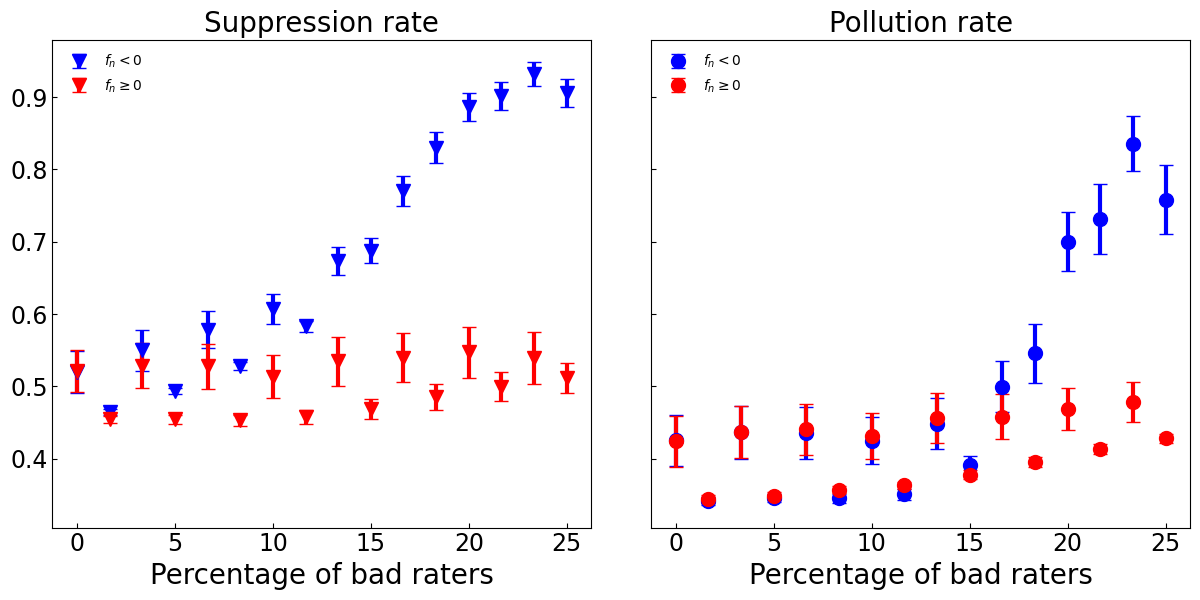

In [ ]:
colors = {
    "fn<0": "blue",
    "fn>=0": "red",
}

helpfulness = "helpfulness_True"

# We only need 2 panels now: suppression + pollution
metrics_to_plot = ["p_h_U", "p_u_H"]
n_rows = 1
n_cols = len(metrics_to_plot)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(6 * n_cols, 6 * n_rows),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)


# Control padding with constrained layout
fig.set_constrained_layout_pads(
    w_pad=0.1,
    h_pad=0.1,
    wspace=0.1,
    hspace=0.1,
)

for col, metric in enumerate(metrics_to_plot):
    ax = axes[col]

    # Loop over fn conditions: <0 (blue) and >=0 (red)
    for condition in conditions:  # assuming conditions = ["fn_neg", "fn_pos"]
        key = f"{helpfulness}_{condition}"
        if key not in data_summary:
            print(f"Key {key} not in data")
            continue
        df_summary = data_summary[key]

        x = df_summary["st_prop"]
        y_mean = df_summary[f"{metric}_mean"]
        y_lower = df_summary[f"{metric}_ci_lower"]
        y_upper = df_summary[f"{metric}_ci_upper"]
        yerr = [y_mean - y_lower, y_upper - y_mean]

        print(f"{condition} - {metric} - mean: {y_mean.values[0]}")
        # Choose marker based on metric
        marker = "v" if metric == "p_h_U" else "o"

        ax.errorbar(
            x,
            y_mean,
            yerr=yerr,
            fmt=marker,
            markersize=10,
            capsize=5,
            color=colors[condition],
            label=f"{condition_names[condition]}",
        )

    ax.tick_params(direction="in")
    ax.set_xlabel(ax_labels["st_prop"])

    import matplotlib.ticker as mticker

    # ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_integer_ticks))
    # ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_integer_ticks))

    ax.legend()

    ax.set_title(metric_names[metric], fontsize=20)

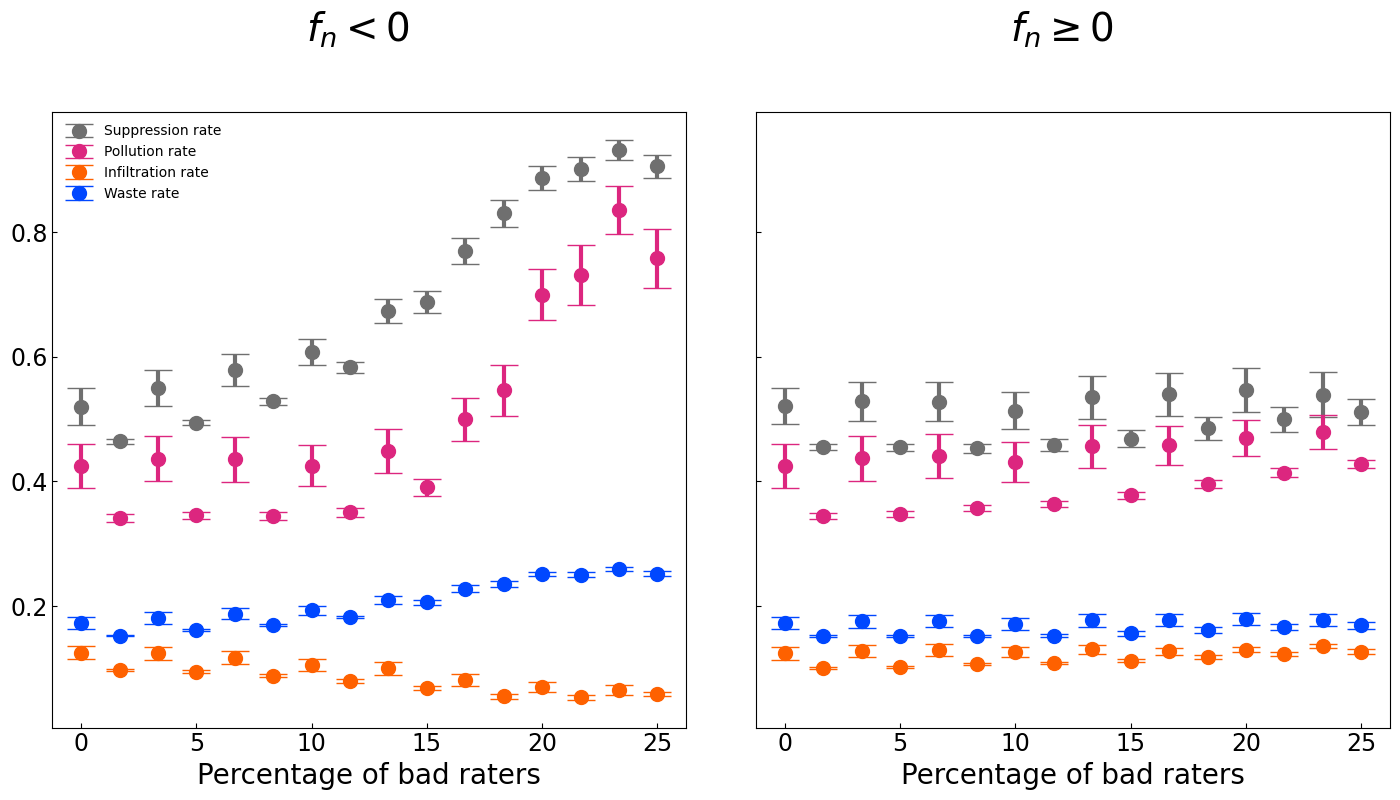

In [9]:
# plot
colors = ["#6F6F6F", "#DC267F", "#FE6100", "#0047FF"]  # black, pink, orange, blue


helpfulness = "helpfulness_True"

# Set up subplot grid: 4 metrics × 2 conditions
n_rows = 1
n_cols = len(conditions)
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(7 * n_cols, 8 * n_rows),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

# Control padding with constrained layout
fig.set_constrained_layout_pads(
    w_pad=0.1,  # horizontal padding between subplots
    h_pad=0.1,  # vertical padding between subplots
    wspace=0.1,  # width space between subplots (similar to wspace in subplots_adjust)
    hspace=0.1,  # height space between subplots (similar to hspace in subplots_adjust)
)


# Plot each metric
for col, condition in enumerate(conditions):
    # Filter for condition
    key = f"{helpfulness}_{condition}"
    if key not in data_summary:
        print(f"Key {key} not in data")
        continue
    else:
        df_summary = data_summary[key]

    ax = axes[col]

    for i, metric in enumerate(metrics):
        # Get the data for this metric
        x = df_summary["st_prop"]
        y_mean = df_summary[f"{metric}_mean"]
        y_lower = df_summary[f"{metric}_ci_lower"]
        y_upper = df_summary[f"{metric}_ci_upper"]
        yerr = [y_mean - y_lower, y_upper - y_mean]

        # Scatter + error bars
        ax.errorbar(
            x,
            y_mean,
            yerr=yerr,
            fmt="o",
            markersize=10,
            capsize=10,
            color=colors[i],
            label=metric_names[metric],
        )
    # ax.set_ylim(0, 1)
    # Customize the plot
    ax.tick_params(direction="in")
    ax.set_xlabel(ax_labels["st_prop"])
    import matplotlib.ticker as mticker

    # # Apply the formatter to the y-axis
    # ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_integer_ticks))
    # ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_integer_ticks))

    if col == 0:
        ax.legend()

    if col == 0:
        ax.text(
            0.4,
            1.1,
            "$f_n < 0$",
            transform=ax.transAxes,
            fontsize=28,
            va="bottom",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.1", facecolor="white", edgecolor="white"),
        )
    elif col == 1:
        ax.text(
            0.4,
            1.1,
            "$f_n \geq 0$",
            transform=ax.transAxes,
            fontsize=28,
            va="bottom",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.1", facecolor="white", edgecolor="white"),
        )

# import os

# # Current working directory (where notebook is running)
# cwd = os.getcwd()
# # Exp type is the parent folder name
# exp = os.path.basename(cwd)
# exp=exp.replace("multi_", "")
# # Save outputs
# plt.savefig(
#     f"FP_count/{exp}_{helpfulness}_ci.png", dpi=300, bbox_inches="tight"
# )
# plt.savefig(
#     f"FP_count/{exp}_{helpfulness}_ci.pdf", dpi=300, bbox_inches="tight"
# )

# plt.show()

## Plot 3 panels (with filtered data)

## Read filtered data 

In [10]:
df

,params,run_result_dir,n_H,n_U,n_h,n_u,p_u_H,p_h_U,p_H_u,p_U_h,condition,n_uH,n_hU,no_run,st_prop
0,1-r_fun-0.100000,/N/project/community_notes_manip/communitynote...,2026,7923,2568,7381,0.396841,0.524143,0.108928,0.169885,fn>=0,804.0,1346.0,1.0,10.0000
1,1-r_fun-0.133333,/N/project/community_notes_manip/communitynote...,3818,16182,5213,14787,0.740178,0.809707,0.191114,0.260845,all,2826.0,4221.0,1.0,13.3333
2,1-r_fun-0.000000,/N/project/community_notes_manip/communitynote...,4272,15728,5198,14802,0.322331,0.443055,0.093028,0.146427,all,1377.0,2303.0,1.0,0.0000
3,1-r_fun-0.250000,/N/project/community_notes_manip/communitynote...,2872,17128,5076,14924,0.487465,0.710008,0.093809,0.210416,all,1400.0,3604.0,1.0,25.0000
4,1-r_fun-0.250000,/N/project/community_notes_manip/communitynote...,1017,8853,2561,7309,0.508358,0.804764,0.070735,0.232802,fn<0,517.0,2061.0,1.0,25.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,100-r_fun-0.100000,/N/project/community_notes_manip/communitynote...,2465,7571,2606,7430,0.356592,0.391404,0.118304,0.134725,fn>=0,879.0,1020.0,100.0,10.0000
4412,100-r_fun-0.233333,/N/project/community_notes_manip/communitynote...,2689,7408,2653,7444,0.402752,0.394648,0.145486,0.141334,fn>=0,1083.0,1047.0,100.0,23.3333
4413,100-r_fun-0.233333,/N/project/community_notes_manip/communitynote...,228,9675,2560,7343,1.000000,1.000000,0.031050,0.264599,fn<0,228.0,2560.0,100.0,23.3333
4414,100-r_fun-0.000000,/N/project/community_notes_manip/communitynote...,4389,15611,5197,14803,0.341763,0.444102,0.101331,0.147844,all,1500.0,2308.0,100.0,0.0000


In [11]:
# Load data
metrics = ["n_filtered", "bad_filtered_rate", "bad_filtered_over_bad"]
conditions = ["fn<0", "fn>=0"]
# Read & prepare data
df = pd.read_csv(f"{out_dir}/filtered_count/{helpfulness}.csv")
df = df.rename(columns={"bhvr_rate": "st_prop"})
df["st_prop"] = pd.to_numeric(df["st_prop"], errors="coerce")
df["st_prop"] = pd.to_numeric(df["st_prop"], errors="coerce")
df["bad_filtered_rate"] = df.apply(
    lambda x: x["n_filtered_bad"] / x["n_filtered"] if x["n_filtered"] > 0 else 0,
    axis=1,
)
df["bad_filtered_over_bad"] = df.apply(
    lambda x: x["n_filtered_bad"] / x["n_bad"] if x["n_bad"] > 0 else 0, axis=1
)

# Group by y values, compute mean and CI for each metric
agg_funcs = {}
for metric in metrics:
    agg_funcs["condition"] = ("condition", "first")
    agg_funcs[metric + "_mean"] = (metric, "mean")
    agg_funcs[metric + "_ci_lower"] = (metric, lambda x: get_ci(x.values)[0])
    agg_funcs[metric + "_ci_upper"] = (metric, lambda x: get_ci(x.values)[1])

df_summary = df.groupby("st_prop").agg(**agg_funcs).reset_index()

print(df_summary["bad_filtered_rate_mean"].describe())
data_summary[f"{helpfulness}_filtered"] = df_summary

NameError: name 'out_dir' is not defined

col: 0, condition: fn<0
Plotting other metrics
col: 1, condition: fn>=0
Plotting other metrics
col: 2, condition: filtered
Plotting filtered metrics


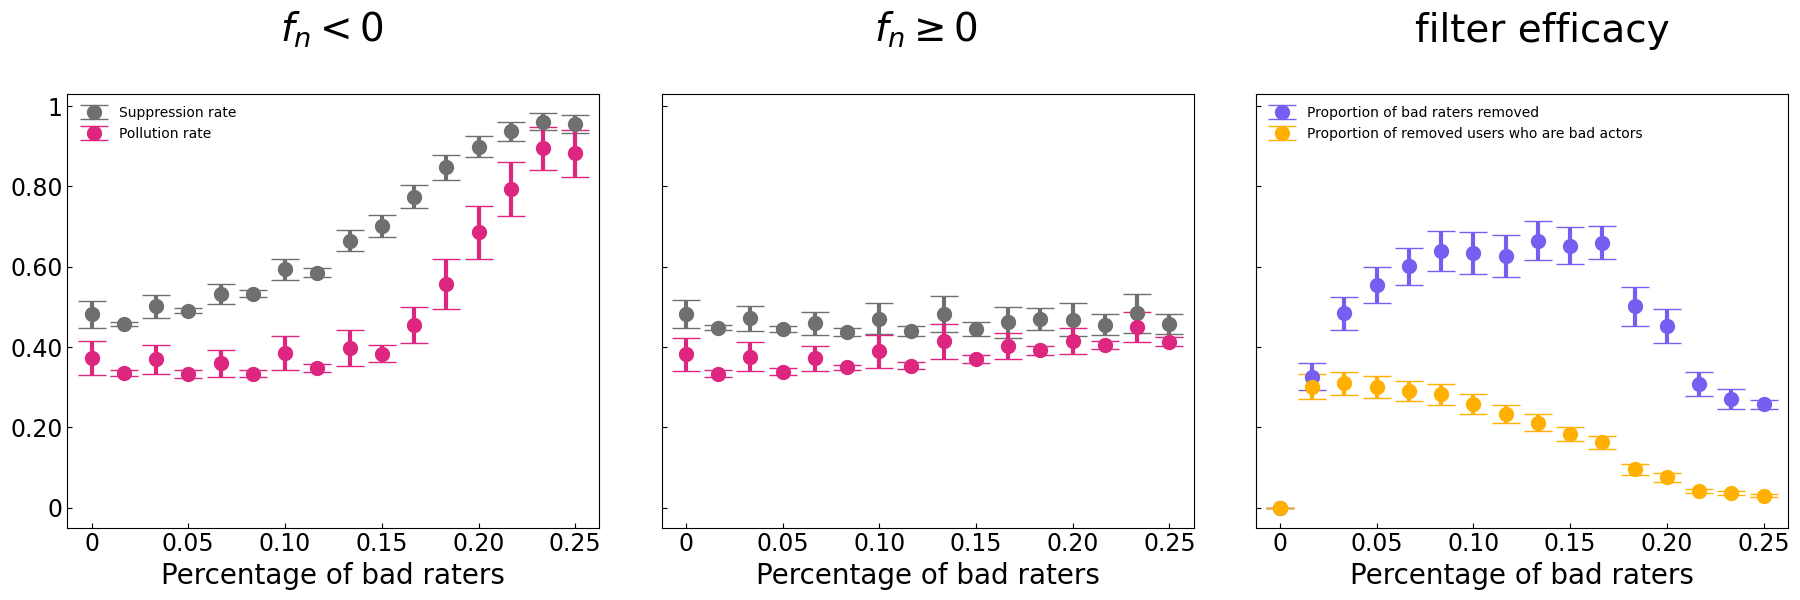

In [ ]:
FIG_NAME = "Fig34."

plot_conditions = ["fn<0", "fn>=0", "filtered"]

helpfulness = "helpfulness_True"

# Set up subplot grid: 4 metrics × 2 conditions
n_rows = 1
n_cols = len(conditions) + 1
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(6 * n_cols, 6 * n_rows),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

# Control padding with constrained layout
fig.set_constrained_layout_pads(
    w_pad=0.1,  # horizontal padding between subplots
    h_pad=0.1,  # vertical padding between subplots
    wspace=0.1,  # width space between subplots (similar to wspace in subplots_adjust)
    hspace=0.1,  # height space between subplots (similar to hspace in subplots_adjust)
)


# Plot each metric
for col, condition in enumerate(plot_conditions):
    # Filter for condition
    key = f"{helpfulness}_{condition}"
    print(f"col: {col}, condition: {condition}")
    if key not in data_summary:
        print(f"Key {key} not in data")
        continue
    else:
        df_summary = data_summary[key]

    ax = axes[col]
    if condition == "filtered":
        sub_metrics = ["bad_filtered_rate", "bad_filtered_over_bad"]
        sub_names = {
            "bad_filtered_rate": "Proportion of bad raters removed",
            "bad_filtered_over_bad": "Proportion of removed users who are bad actors",
        }
        print("Plotting filtered metrics")
        colors = [
            "#785EF0",
            "#FFB000",
        ]  # purple, gold
    else:
        print("Plotting other metrics")
        sub_metrics = ["p_h_U", "p_u_H"]
        sub_names = names
        colors = [
            "#6F6F6F",
            "#DC267F",
            "#FE6100",
            "#0047FF",
        ]  # black, pink, orange, blue

    for i, metric in enumerate(sub_metrics):
        # Get the data for this metric
        x = df_summary["st_prop"]
        y_mean = df_summary[f"{metric}_mean"]
        y_lower = df_summary[f"{metric}_ci_lower"]
        y_upper = df_summary[f"{metric}_ci_upper"]
        yerr = [y_mean - y_lower, y_upper - y_mean]

        # Scatter + error bars
        ax.errorbar(
            x,
            y_mean,
            yerr=yerr,
            fmt="o",
            markersize=10,
            capsize=10,
            color=colors[i],
            label=sub_names[metric],
        )
    # ax.set_ylim(0, 1)
    # Customize the plot
    ax.tick_params(direction="in")
    ax.set_xlabel(ax_labels["st_prop"])
    import matplotlib.ticker as mticker

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_integer_ticks))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_integer_ticks))

    if col != 1:
        ax.legend()

    if col == 0:
        ax.text(
            0.4,
            1.1,
            "$f_n < 0$",
            transform=ax.transAxes,
            fontsize=28,
            va="bottom",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.1", facecolor="white", edgecolor="white"),
        )
    elif col == 1:
        ax.text(
            0.4,
            1.1,
            "$f_n \geq 0$",
            transform=ax.transAxes,
            fontsize=28,
            va="bottom",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.1", facecolor="white", edgecolor="white"),
        )
    elif col == 2:
        ax.text(
            0.3,
            1.1,
            "filter efficacy",
            transform=ax.transAxes,
            fontsize=28,
            va="bottom",
            ha="left",
            bbox=dict(boxstyle="round,pad=0.1", facecolor="white", edgecolor="white"),
        )
import os

# Current working directory (where notebook is running)
cwd = os.getcwd()
plot_dir = "plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
# Save outputs
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{plot_dir}/{FIG_NAME}{helpfulness}.pdf", dpi=300, bbox_inches="tight")

plt.show()